In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats import median_abs_deviation, chi2
import seaborn as sns
import statsmodels.api as sm

# Data preprocessing

In [2]:
df_digpd = pd.read_excel('DIGPD data/dig_pd_2019_11.xlsx')

df_pca_digpd = pd.read_csv('Ancestry/Genetic ancestry (principal components) - DIGPD.csv', index_col=0)

df_grs_digpd = pd.read_csv('LDpred2 - Results/GRS - DIGPD.csv', index_col=0)
df_grs_digpd = df_grs_digpd.sub(df_grs_digpd.mean(axis=0)).div(df_grs_digpd.std(axis=0))

df_gba_digpd = pd.read_csv('DIGPD data/GBA/DIGPD - GBA status.csv', index_col=0)
df_apoe_digpd = pd.read_csv('DIGPD data/ApoE e4/APOE SNP data.csv', index_col=0)

In [3]:
df_digpd_mlm = df_digpd[['PATIENT', 'visite', 'Age', 'Age_diag', 'YEARSEDUC', 'sexe1', 'ScoreMMSE_Corrige']].copy()

# Recode patient identifiers
df_digpd_mlm['PATNO'] = df_digpd_mlm['PATIENT'].apply(lambda x: x[:5]).astype('int64')
df_digpd_mlm = df_digpd_mlm.set_index('PATNO')

# Intercept
df_digpd_mlm['Intercept'] = 1.

# Age at PD diagnosis
df_digpd_mlm['Age at PD diagnosis'] = df_digpd_mlm[df_digpd_mlm['visite'] == 1]['Age_diag']

# Time fron PD onset
df_digpd_mlm['Time from PD onset'] = df_digpd_mlm['Age'] - df_digpd_mlm['Age_diag'].fillna(method='ffill')

# Education level
df_digpd_mlm['Education level'] = df_digpd_mlm[df_digpd_mlm['visite'] == 1]['YEARSEDUC']

# Sex
df_digpd_mlm['Sex'] = df_digpd_mlm.loc[df_digpd_mlm['visite'] == 1, 'sexe1']

# APOE and GBA
df_digpd_mlm[['rs429358-C', 'rs7412-C']] = df_apoe_digpd
df_digpd_mlm[['Number of severe GBA mutations', 'Number of mild GBA mutations',
              'Number of undetermined GBA mutations']] = df_gba_digpd

# Genetic ancestry
df_digpd_mlm[[f'PC{i}' for i in range(1, 5)]] = df_pca_digpd[[f'PC{i}' for i in range(1, 5)]]

# Genetic risk scores
df_digpd_mlm[df_grs_digpd.columns] = df_grs_digpd

# Reset index and keep columns of interest
df_digpd_mlm = df_digpd_mlm.reset_index()[
    ['PATNO', 'Intercept', 'Sex', 'Age at PD diagnosis', 'ScoreMMSE_Corrige'] + 
    ['Time from PD onset', 'Education level'] +
    ['Number of mild GBA mutations', 'Number of undetermined GBA mutations', 'rs429358-C', 'rs7412-C'] +
    [f'PC{i}' for i in range(1, 5)] + 
    list(df_grs_digpd.columns)
]
df_digpd_mlm = df_digpd_mlm.rename(columns={'ScoreMMSE_Corrige': 'MMSE'})

# Drop subjects with no genetic data
df_digpd_mlm = df_digpd_mlm[~df_digpd_mlm[df_grs_digpd.columns].isna().all(axis=1)]

# Drop visits with no MMSE
df_digpd_mlm = df_digpd_mlm[~df_digpd_mlm['MMSE'].isna()]

# Make a copy to get a de-fragmented DataFrame
df_digpd_mlm = df_digpd_mlm.copy()

# Check that there is no missing value
df_digpd_mlm = df_digpd_mlm[~df_digpd_mlm.isna().any(axis=1)].copy()
assert not df_digpd_mlm.isna().any().any()

/Users/johann.faouzi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


# Main analyses

The reviewers asked for two main changes in the analyses:
* Replacing the `Visit` variable with `Time since PD onset` variable
* Adding an `Education level` variable as a covariate
* Plotting the residuals to check for normality
* Checking if the combined model is significantly better than each individual model

In [4]:
def run_statistical_analyses_updated(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        # print(model.summary())
        
        # Save the residuals
        residuals[col] = df_copy['MMSE'] - model.fittedvalues

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res, residuals

In [5]:
def plot_residuals(residuals, col, title=''):
    ax = sns.histplot(residuals[col], stat='density', kde=True)
    _ = ax.set_ylabel('');
    _ = ax.set_xlabel('Residuals')
    _ = ax.set_title(title)

In [6]:
def compare_combined_prs_vs_individual_prs(df, grs_cols):
    """Likelihood ratio tests."""
    
    # Save the models
    models = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each individual PRS
    for col in grs_cols:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000, reml=False)

        # print(model.summary())
        
        # Save the residuals
        models[col] = model

    # Combined PRS
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358-C', 'rs7412-C'] +
        ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
        grs_cols
    )

    model_combined = sm.MixedLM(
        endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
    )
    model_combined = model_combined.fit(maxiter=2000, reml=False)

    # print(model_combined.summary())

    pvalues = {
        col: 1 - chi2(df=len(grs_cols) - 1).cdf(-2 * (models[col].llf - model_combined.llf))
        for col in grs_cols
    }
    
    return pvalues

# Additional analyses

The reviewers have asked for two additional analyses in particular:
* Adding interactions terms between (i) the PRS variable and (ii) each APOE and GBA variable.
* Running the analyses without the APOE and GBA variables as covariates.

## Interactions terms

In [7]:
def run_statistical_analyses_with_interaction_terms(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Define APOE and GBA variable names
    apoe_gba_columns = [
        'Number of mild GBA mutations',
        'Number of undetermined GBA mutations',
        'rs429358-C',
        'rs7412-C'
    ]
    interactions_columns = [f'Interaction {i}' for i in range(1, len(apoe_gba_columns) + 1)]
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:
        
        # Add interaction terms
        df_copy[interactions_columns] = (
            df_copy[apoe_gba_columns].mul(df_copy[col], axis=0)
        )

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            ['rs429358-C', 'rs7412-C'] +
            ['Number of mild GBA mutations', 'Number of undetermined GBA mutations'] +
            interactions_columns +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_temp = pd.DataFrame(pd.concat([
            model.params[[col] + interactions_columns],
            model.conf_int().loc[[col] + interactions_columns, 0],
            model.conf_int().loc[[col] + interactions_columns, 1],
            model.pvalues[[col] + interactions_columns]
        ])).T
        df_temp.columns = pd.MultiIndex.from_product((
            ['Effect size', 'Lower bound (95%-CI)', 'Upper bound (95%-CI)', 'p-value'],
            ['GRS'] + interactions_columns
        ))
        df_res.append(df_temp)
        
        # print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.concat(df_res, axis=0)
    df_res.index = grs_col

    return df_res

## Without APOE and GBA covariates

In [8]:
def run_statistical_analyses_without_apoe_and_gba(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores

    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value

    """

    # Create an empty list to save all the results
    df_res = []
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.
    
    # Standardize each PRS
    grs_col = [col for col in df.columns if col.startswith('GRS__')]
    df_copy[grs_col] = df_copy[grs_col].sub(df_copy[grs_col].mean(axis=0)).div(df_copy[grs_col].std(axis=0))

    # For each PRS
    for col in grs_col:

        # Define the exogeneous variables
        exog = (
            ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
            [f'PC{i}' for i in range(1, 5)] +
            [col]
        )
    
        model = sm.MixedLM(
            endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
        )
        model = model.fit(maxiter=2000)

        df_res.append([
            model.params[col],
            model.conf_int().loc[col, 0],
            model.conf_int().loc[col, 1],
            model.pvalues[col]
        ])
        
        # print(model.summary())

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=[col for col in df.columns if col.startswith('GRS__')],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )

    return df_res

### Main analyses

In [9]:
df_res, residuals = run_statistical_analyses_updated(df_digpd_mlm)

In [10]:
df_res[df_res['p-value'] < 0.05]

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__grasby_2020__mean_pericalcarine_thickavg.txt,0.204504,0.042686,0.366322,0.013250
GRS__grasby_2020__mean_posteriorcingulate_thickavg.txt,-0.160908,-0.321774,-0.000043,0.049939
GRS__grasby_2020__mean_precuneus_thickavg.txt,-0.216651,-0.385067,-0.048235,0.011692
GRS__grasby_2020__mean_superiorparietal_thickavg.txt,-0.172196,-0.343208,-0.001185,0.048434
GRS__schwartzentruber_2021__alzheimer_disease_or_family_history.txt,-0.268821,-0.521944,-0.015698,0.037386


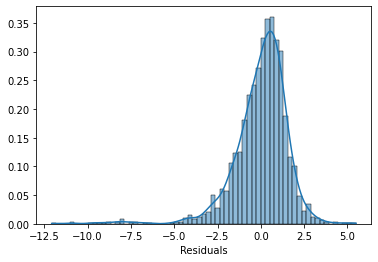

In [11]:
plot_residuals(residuals, 'GRS__savage_2018__intelligence.txt')

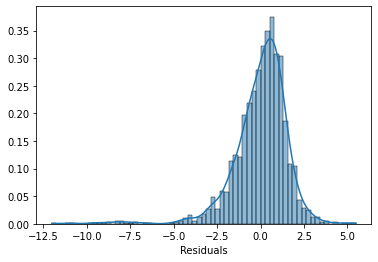

In [12]:
plot_residuals(residuals, 'GRS__lee_2018__cognitive_performance.txt')

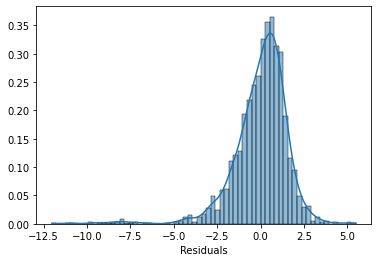

In [13]:
plot_residuals(residuals, 'GRS__davies_2016__reasoning.txt')

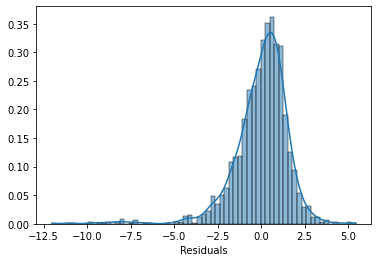

In [14]:
plot_residuals(residuals, 'GRS__lee_2018__educational_attainment.txt')

### With interaction terms

In [15]:
df_res_with_interaction_terms = run_statistical_analyses_with_interaction_terms(df_digpd_mlm)

In [16]:
df_res_with_interaction_terms[(df_res_with_interaction_terms['p-value'] < 0.0001).any(axis=1)]

Empty DataFrame
Columns: [(Effect size, GRS), (Effect size, Interaction 1), (Effect size, Interaction 2), (Effect size, Interaction 3), (Effect size, Interaction 4), (Lower bound (95%-CI), GRS), (Lower bound (95%-CI), Interaction 1), (Lower bound (95%-CI), Interaction 2), (Lower bound (95%-CI), Interaction 3), (Lower bound (95%-CI), Interaction 4), (Upper bound (95%-CI), GRS), (Upper bound (95%-CI), Interaction 1), (Upper bound (95%-CI), Interaction 2), (Upper bound (95%-CI), Interaction 3), (Upper bound (95%-CI), Interaction 4), (p-value, GRS), (p-value, Interaction 1), (p-value, Interaction 2), (p-value, Interaction 3), (p-value, Interaction 4)]
Index: []

### Without APOE and GBA covariates

In [17]:
df_res_without_apoe_and_gba = run_statistical_analyses_without_apoe_and_gba(df_digpd_mlm)

In [18]:
df_res_without_apoe_and_gba[df_res_without_apoe_and_gba['p-value'] < 0.0005]

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value


### Combined PRS vs individual PRS

In [19]:
compare_combined_prs_vs_individual_prs(
    df_digpd_mlm, [
        'GRS__savage_2018__intelligence.txt',
        'GRS__lee_2018__cognitive_performance.txt',
        'GRS__davies_2016__reasoning.txt',
        'GRS__lee_2018__educational_attainment.txt'
    ]
)

{'GRS__savage_2018__intelligence.txt': 0.4807155470647698,
 'GRS__lee_2018__cognitive_performance.txt': 0.27400157073521925,
 'GRS__davies_2016__reasoning.txt': 0.4849195950599412,
 'GRS__lee_2018__educational_attainment.txt': 0.3481324756377242}

### Correlations

In [20]:
cognitive_phenotypes = [
    'GRS__davies_2016__reasoning.txt',
    'GRS__lee_2018__cognitive_performance.txt',
    'GRS__lee_2018__educational_attainment.txt',
    'GRS__savage_2018__intelligence.txt'
]

df_digpd_mlm[cognitive_phenotypes].corr()

,GRS__davies_2016__reasoning.txt,GRS__lee_2018__cognitive_performance.txt,GRS__lee_2018__educational_attainment.txt,GRS__savage_2018__intelligence.txt
GRS__davies_2016__reasoning.txt,1.000000,0.578484,0.334646,0.465514
GRS__lee_2018__cognitive_performance.txt,0.578484,1.000000,0.539441,0.781637
GRS__lee_2018__educational_attainment.txt,0.334646,0.539441,1.000000,0.512557
GRS__savage_2018__intelligence.txt,0.465514,0.781637,0.512557,1.000000


# Save results

In [22]:
df_res.head()

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__adams_2016__intracranial_volume.txt,-0.017414,-0.199840,0.165013,0.851591
GRS__chia_2021__lewy_body_dementia.txt,-0.211686,-0.488932,0.065560,0.134525
GRS__davies_2016__memory_performance.txt,-0.158930,-0.319849,0.001989,0.052900
GRS__davies_2016__reasoning.txt,0.165139,-0.001006,0.331285,0.051404
GRS__davies_2018__reaction_time.txt,-0.066645,-0.229242,0.095951,0.421769


In [21]:
df_res_without_apoe_and_gba.head()

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
GRS__adams_2016__intracranial_volume.txt,-0.025835,-0.207895,0.156225,0.780913
GRS__chia_2021__lewy_body_dementia.txt,-0.196788,-0.354890,-0.038686,0.014705
GRS__davies_2016__memory_performance.txt,-0.162539,-0.322855,-0.002223,0.046907
GRS__davies_2016__reasoning.txt,0.173844,0.009436,0.338252,0.038224
GRS__davies_2018__reaction_time.txt,-0.074722,-0.236597,0.087152,0.365607


In [23]:
df_res_with_interaction_terms.head()

Effect size                \
                                                 GRS Interaction 1   
GRS__adams_2016__intracranial_volume.txt    0.647980      0.232176   
GRS__chia_2021__lewy_body_dementia.txt      0.457031     -0.963659   
GRS__davies_2016__memory_performance.txt   -0.443050      0.533866   
GRS__davies_2016__reasoning.txt             0.222911      0.158001   
GRS__davies_2018__reaction_time.txt         0.323236      0.029270   

                                                                      \
                                         Interaction 2 Interaction 3   
GRS__adams_2016__intracranial_volume.txt     -0.427215     -0.267176   
GRS__chia_2021__lewy_body_dementia.txt        0.140154     -0.301398   
GRS__davies_2016__memory_performance.txt     -0.198102     -0.331661   
GRS__davies_2016__reasoning.txt               0.108123      0.273945   
GRS__davies_2018__reaction_time.txt           0.084952      0.383140   

                                                       Lower bound (95%-CI)  \
                                         Interaction 4                  GRS   
GRS__adams_2016__intracranial_volume.txt     -0.318976            -0.296188   
GRS__chia_2021__lewy_body_dementia.txt       -0.322168            -0.685077   
GRS__davies_2016__memory_performance.txt      0.194191            -1.459181   
GRS__davies_2016__reasoning.txt              -0.068754            -0.837069   
GRS__davies_2018__reaction_time.txt          -0.268461            -0.668641   

                                                                      \
                                         Interaction 1 Interaction 2   
GRS__adams_2016__intracranial_volume.txt     -1.007012     -1.538053   
GRS__chia_2021__lewy_body_dementia.txt       -2.172339     -0.461321   
GRS__davies_2016__memory_performance.txt     -1.519632     -1.133735   
GRS__davies_2016__reasoning.txt              -0.963311     -0.753975   
GRS__davies_2018__reaction_time.txt          -0.814446     -1.115331   

                                                                      \
                                         Interaction 3 Interaction 4   
GRS__adams_2016__intracranial_volume.txt     -0.623164     -0.817786   
GRS__chia_2021__lewy_body_dementia.txt       -0.695948     -0.899436   
GRS__davies_2016__memory_performance.txt     -0.685695     -0.335633   
GRS__davies_2016__reasoning.txt              -0.097717     -0.617043   
GRS__davies_2018__reaction_time.txt           0.071664     -0.789142   

                                         Upper bound (95%-CI)                \
                                                          GRS Interaction 1   
GRS__adams_2016__intracranial_volume.txt             1.592148      1.471364   
GRS__chia_2021__lewy_body_dementia.txt               1.599140      0.245021   
GRS__davies_2016__memory_performance.txt             0.573081      2.587363   
GRS__davies_2016__reasoning.txt                      1.282891      1.279313   
GRS__davies_2018__reaction_time.txt                  1.315114      0.872986   

                                                                      \
                                         Interaction 2 Interaction 3   
GRS__adams_2016__intracranial_volume.txt      0.683622      0.088811   
GRS__chia_2021__lewy_body_dementia.txt        0.741630      0.093153   
GRS__davies_2016__memory_performance.txt      0.737531      0.022372   
GRS__davies_2016__reasoning.txt               0.970221      0.645607   
GRS__davies_2018__reaction_time.txt           1.285235      0.694615   

                                                         p-value  \
                                         Interaction 4       GRS   
GRS__adams_2016__intracranial_volume.txt      0.179834  0.178587   
GRS__chia_2021__lewy_body_dementia.txt        0.255099  0.432859   
GRS__davies_2016__memory_performance.txt      0.724016  0.392785   
GRS__davies_2016__reasoning.txt               0.479536  0.680211   
GRS__davies_20

In [24]:
df_res.to_csv('Revision/Johann/Main updated analyses/DIGPD/table.csv')
df_res_without_apoe_and_gba.to_csv('Revision/Johann/Without APOE and GBA covariates/DIGPD/table.csv')
df_res_with_interaction_terms.to_csv('Revision/Johann/With interaction terms/DIGPD/table.csv')

In [21]:
df_digpd_mlm[cognitive_phenotypes].corr().to_csv('Revision/Johann/Correlations/DIGPD.csv')

In [23]:
pd.Series(compare_combined_prs_vs_individual_prs(
    df_digpd_mlm, [
        'GRS__savage_2018__intelligence.txt',
        'GRS__lee_2018__cognitive_performance.txt',
        'GRS__davies_2016__reasoning.txt',
        'GRS__lee_2018__educational_attainment.txt'
    ]
)).to_csv('Revision/Johann/Combination/DIGPD.csv')

# Education level

In [30]:
def run_statistical_analyses_education_level(df):
    """Run the statistical analyses.

    Parameters
    ----------
    df : DataFrame
        Matrix whose rows are the (subject, visit) pairs and whose columns are
            - the cognitive scores for each subject at each visit
            - the exogeneous variables
            - the group (subject ID) variable
            - the polygenic risk scores
        
    Returns
    -------
    df_res : DataFrame
        Matrix whose rows are the polygenic risk scores and whose columns are,
        for each individual progression parameter:
            - the coefficient associated to the polygenic risk score variable
            - the lower bound of the corresponding 95% confidence interval
            - the upper bound of the corresponding 95% confidence interval
            - the corresponding p-value
    
    """

    # Create an empty list to save all the results
    df_res = []
    
    # Create an empty dictionary to save the residuals
    residuals = {}
    
    # Make a copy to add an intercept
    df_copy = df.copy()
    df_copy['Intercept'] = 1.

    # Define the exogeneous variables
    exog = (
        ['Intercept', 'Age at PD diagnosis', 'Sex', 'Time from PD onset', 'Education level'] +
        [f'PC{i}' for i in range(1, 5)] +
        ['rs429358-C', 'rs7412-C'] +
        ['Number of mild GBA mutations', 'Number of undetermined GBA mutations']
    )

    model = sm.MixedLM(
        endog=df_copy['MMSE'], exog=df_copy[exog], groups=df_copy['PATNO']
    )
    model = model.fit(maxiter=2000)

    df_res.append([
        model.params['Education level'],
        model.conf_int().loc['Education level', 0],
        model.conf_int().loc['Education level', 1],
        model.pvalues['Education level']
    ])

    # Transform the list into a DataFrame
    df_res = pd.DataFrame(
        df_res,
        index=['Education level'],
        columns=('Coefficient', 'Lower bound (95% CI)', 'Upper bound (95% CI)', 'p-value')
    )
    
    return df_res

In [31]:
run_statistical_analyses_education_level(df_digpd_mlm)

,Coefficient,Lower bound (95% CI),Upper bound (95% CI),p-value
Education level,0.122498,0.083215,0.161781,9.850957e-10
